- 相关原始数据已无，jg_sg_df3.csv数据为特征工程好的数据
- 数据清洗处理方式可直接看5中操作，模型预测/超参调整看下方
- xgb：https://blog.csdn.net/qq_36535820/article/details/120507280
- lightgbm: https://blog.csdn.net/zhong_ddbb/article/details/106244036
- https://blog.csdn.net/weixin_39807102/article/details/81912566?spm=1001.2101.3001.6650.4&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-4-81912566-blog-106244036.pc_relevant_multi_platform_whitelistv1&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-4-81912566-blog-106244036.pc_relevant_multi_platform_whitelistv1&utm_relevant_index=6
- https://blog.csdn.net/huacha__/article/details/81057150?spm=1001.2101.3001.6650.3&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-3-81057150-blog-81912566.pc_relevant_multi_platform_whitelistv1&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-3-81057150-blog-81912566.pc_relevant_multi_platform_whitelistv1&utm_relevant_index=6
- https://mp.weixin.qq.com/s/XxFHmxV4_iDq8ksFuZM02w

In [1]:
import sys
sys.path.append('/data/apps/modules/jupyter')
import warnings
warnings.filterwarnings("ignore")
import math
import time
import feather
import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from helper.spark_helper import *
from helper.presto_helper import query_presto
from helper.csv_helper import *
from helper.pandas_helper import *
from helper.presto_helper import query_hive_wy

# 用户单量统计-偏好划分

In [2]:
def get_user_detail_df(city_id,start_date,end_date):

    d_df=get_df_from_csv_table(query_presto(f'''
        select user_id,bike_sn,order_id,city_id,event_day
        from dwd.dwd_bd_order_detail_da
        where city_id={city_id} and event_day between '{start_date}' and '{end_date}'
    '''))
    
    return d_df


city_id=196
start_date='20210207'
end_date='20210407'

#用户60天内单量统计
user_detail_df=get_user_detail_df(city_id,start_date,end_date)
user_statistics_df=user_detail_df.groupby('user_id').bike_sn.count().reset_index()

In [3]:
user_detail_df.head()

,user_id,bike_sn,order_id,city_id,event_day
0,6863630,802213676,2104053503888711745,196,20210405
1,8213994,812211252,2104053586633941010,196,20210405
2,47327905,802214945,2104050275214155800,196,20210405
3,6857139,802214520,2104052243382919213,196,20210405
4,6665877,802212064,2104052807701356624,196,20210405


In [4]:
user_statistics_df.head()

,user_id,bike_sn
0,1734281,1
1,1758254,7
2,1888917,3
3,2039255,4
4,2044893,9


In [5]:
user_detail_df.to_csv('user_detail_df.csv')

In [6]:
user_statistics_df.to_csv('user_statistics_df.csv')

# 用户基础特征获取-性别、年龄、手机品牌、操作系统

In [10]:
def get_user_picture_df(city_id_str,event_day):
    user_picture = get_df_from_csv_table(query_presto(f'''
        select a.user_id, a.city_id, a.gender,a.mobile,a.first_order_time,a.birthday, b.model, b.brand, b.sys_ver
        from
        (select user_id, city_id,birthday, gender, mobile,first_order_time
        from dim.dim_user_info_df
        where city_id in ({city_id_str})
        and gender!=0
        and birthday is not null
        and event_day='{event_day}') a left join
        (select user_id, model , brand, sys_ver
        from dwd.dwd_nf_nf_user_action_da
        where event_day='{event_day}') b on a.user_id=b.user_id
    '''))

    return user_picture

city_id_str=str(city_id)
event_day='20210407'
user_picture_df=get_user_picture_df(city_id_str,event_day)
user_picture_df.to_csv('user_picture_df.csv')

In [25]:
def get_register_span(x):
    """
    用户注册时间跨度
    """
    time_list=x['first_order_time'][:10].split('-')
    time_span=datetime.date(2021,4,7)-\
                datetime.date(int(time_list[0]),int(time_list[1]),int(time_list[2]))
    time_span=time_span.days+1
    return time_span

user_picture_df['age'] = user_picture_df['birthday'].map(lambda x: int(time.strftime("%Y",time.localtime(time.time())))-int(x[:4])+1)
user_picture_df['register_span']=user_picture_df.apply(get_register_span,axis=1)

In [26]:
print(user_statistics_df.shape,user_picture_df.shape)

(40894, 2) (104872, 11)


<AxesSubplot:>

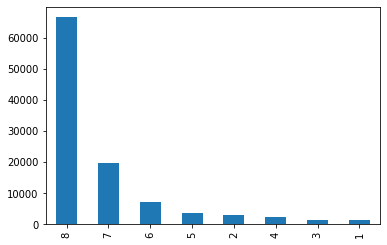

In [27]:
def split_window_func(x):
    """
    用户单量分段    
    """

    if x['order_day_avg']>1:
        return 1
    elif  0.5<x['order_day_avg']<=1:
        return 2
    elif  0.4<x['order_day_avg']<=0.5:
        return 3
    elif  0.3<x['order_day_avg']<=0.4:
        return 4
    elif  0.2<x['order_day_avg']<=0.3:
        return 5
    elif  0.1<x['order_day_avg']<=0.2:
        return 6
    elif  0<x['order_day_avg']<=0.1:
        return 7
    else:
        return 8

merge_df=user_picture_df.merge(user_statistics_df,on='user_id',how='left')
merge_df['order_day_avg']=merge_df.apply(lambda x:x['bike_sn']/60 if x['register_span']>59 else x['bike_sn']/x['register_span'],axis=1)
merge_df['window']=merge_df.apply(split_window_func,axis=1)
merge_df['window'].value_counts().plot.bar()

In [29]:
def get_age_transform(x):
    if x<20:
        return 1
    elif 20<=x<=24:
        return 2
    elif 25<=x<=29:
        return 3
    elif 30<=x<=34:
        return 4
    elif 35<=x<=39:
        return 5
    elif 40<=x<=44:
        return 6
    else:
        return 7
def get_brand_transform(x):
    if x=='HUAWEI':
        return 1
    elif x=='OPPO':
        return 2
    elif x=='vivo':
        return 3
    elif x=='iPhone' or x=='Apple':
        return 4
    elif x=='HONOR':
        return 5
    else:
        return 6

merge_df['age_transformed']=merge_df.age.apply(get_age_transform)    
merge_df['brand_transformed']=merge_df.brand.apply(get_brand_transform)

import re
def edit_ver(x):
    try:
        if type(x)==type(0.1) or type(x)==type(1):
            return 'None'
        elif re.match('\d+\..*', x):
            return 'Android '+re.search('\d+', x)[0]
        elif re.match('Android \d+\..*', x):
            return 'Android '+re.search('\d+', x)[0]
        elif re.match('Android \d+$', x):
            return x
        elif re.match('iOS \d+$', x):
            return x
        elif re.match('iOS\d+\..*', x):
            return 'iOS '+re.search('\d+',x)[0]
        elif re.match('iOS \d+\..*', x):
            return 'iOS '+re.search('\d+',x)[0]
        elif re.match('\d+$', x):
            return 'Android '+x
        else:
            return 'Other'
    except:
        print(type(x))
def get_sys_ver_transform(x):
    if x[:3]=='iOS':
        if x.split(' ')[-1]=='14':
            return 1
        elif x.split(' ')[-1]=='13':
            return 2
        else:
            return 7
    elif x.split(' ')[-1]=='10':
        return 3
    elif x.split(' ')[-1]=='11':
        return 4
    elif x.split(' ')[-1]=='9':
        return 5
    elif x.split(' ')[-1]=='8':
        return 6
    else:
        return 7
merge_df2=merge_df
merge_df2=merge_df2.fillna(0)
merge_df2['sys_ver_transform1']=merge_df2.sys_ver.apply(edit_ver)  
def get_sys_ver_transform(x):
    try:
        if x.split(' ')[-1]=='11':
            return 1
        elif x.split(' ')[-1]=='10':
            return 2
        elif x.split(' ')[-1]=='9':
            return 3
        elif x.split(' ')[-1]=='8':
            return 4
        else:
            return 5
    except:
        print(x)
        
        
merge_df2['sys_ver_transformed']=merge_df2.sys_ver_transform1.apply(get_sys_ver_transform) 

# 极光特征


In [30]:
def edit_query_result(x):
    if x=='查询标签成功-有标签':
        return 1
    else:
        return 0
    
jiguang_df=pd.read_csv('iaudience.csv').rename({'imei/phone/mac/imsi':'mobile'},axis=1)
jiguang_df['query_result']=jiguang_df.查询结果.map(edit_query_result)
jiguang_df=jiguang_df[jiguang_df.query_result==1]

merge_df2['mobile']=merge_df2['mobile'].astype('int')
jg_sg_df=pd.merge(jiguang_df,merge_df2,on='mobile',how='left')

ValueError: invalid literal for int() with base 10: '4c9c845ab01e289351f70e42079b31ff'

# 手机号被加密导致关联失败，好在之前存了一份csv

In [37]:
jg_sg_df3 = pd.read_csv('jg_sg_df3.csv')

In [41]:
jg_sg_df3[['city_id','user_id','mobile','birthday']]

,city_id,user_id,mobile,birthday
0,196.0,9815458.0,18282870056,1982-08-22 00:00:00.000
1,196.0,20735127.0,13568652678,1974-05-02 00:00:00.000
2,196.0,7154820.0,13981566579,1977-04-03 00:00:00.000
3,196.0,20409897.0,18215741718,1998-08-14 00:00:00.000
4,196.0,7131516.0,13981568710,1973-04-11 00:00:00.000
...,...,...,...,...
24605,196.0,6910503.0,17608046298,1996-09-15 00:00:00.000
24606,196.0,9558436.0,15378407761,1996-06-11 00:00:00.000
24607,196.0,48166974.0,18349604777,1986-12-17 00:00:00.000
24608,196.0,6952912.0,18989255752,1981-12-26 00:00:00.000


In [43]:
jg_sg_df3.columns

Index(['Unnamed: 0', 'mobile', '查询结果', 'CPL_HHM_CHILD_HC', 'CPL_INDM_GEND_S',
       'CPL_INDM_MARRC2', 'CPL_INDM_NATI', 'CPL_INDM_AGE_C5',
       'CPL_HHM_CHILD_CHLI', 'CID_MODEL',
       ...
       '数码专卖', 'big_offs', '生鲜配送', '情趣用品', '零售百货', '图书专卖', '二次元专卖', '团购特卖',
       '捕鱼', 'pref'],
      dtype='object', length=432)

In [44]:
transform_list=['CPL_INDM_EDU_LEVEL',
              'CPL_INDM_MARRC2',
              'FIM_FISM_INCL',
              'FIM_FISM_CONL_CIR']
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
lis=[]
for col in transform_list:
    try:
        jg_sg_df3[col+'_transformed'] = lbl.fit_transform(jg_sg_df3[col].astype('category'))
    except:
        lis.append(col)

In [45]:
lis

[]

In [47]:
jg_sg_df3['xxx'] = lbl.fit_transform(jg_sg_df3['CPL_INDM_EDU_LEVEL'].astype('category'))
jg_sg_df3[['xxx','CPL_INDM_EDU_LEVEL']]

,xxx,CPL_INDM_EDU_LEVEL
0,3,高
1,0,None
2,1,中
3,3,高
4,2,低
...,...,...
24605,3,高
24606,2,低
24607,2,低
24608,2,低


In [48]:
jg_sg_df3['GBM_BHM_PURB_CONP']

0                  N
1               None
2               图书专卖
3        N、品牌折扣、图书专卖
4               None
            ...     
24605         二手闲置、N
24606           品牌折扣
24607    数码电脑、品牌折扣、N
24608    数码电脑、N、品牌折扣
24609            土特产
Name: GBM_BHM_PURB_CONP, Length: 24610, dtype: object

In [52]:
jg_sg_df4=jg_sg_df3
catagories_set = set()
for row in jg_sg_df4['GBM_BHM_PURB_CONP']:
    catagories_set |= set(row.split('、'))
catagories_set.discard("")    
catagorijg_sg_df3.window.value_counts()es_set.discard("None")
catagories = list(catagories_set)
catagories_df = pd.DataFrame(columns=catagories)

In [53]:
catagories_df

,家具家电,宠物用品,返现返利,奢侈品,团购特卖,母婴玩具,婚礼筹备,批发专卖,美妆导购,购物导航,数码电脑,分期购,全球导购,酒茶专卖,收藏品,包包配饰,比价,土特产,生鲜配送,网上超市,零食专卖,卖家版,服饰专卖,宠物必备,汽车专卖,图书专卖,二手车,手工制作,海外电商,捕鱼,生鲜专卖,内衣专卖,情趣用品,虚拟商品,化妆品专卖,二手手机,二手闲置,户外运动,海淘,社交电商,免税店,返现,数码专卖,情趣专卖,折扣优惠,优惠券,电动车,美甲,返利返现,信用消费,药品补品,动漫周边,二手车交易,全球美食,批发,零售百货,拍卖,珠宝饰品,农产品,二次元专卖,电影票专卖,手工艺品,儿童用品,品牌特卖,掌上超市,品牌折扣,N


In [54]:
jg_sg_df5=jg_sg_df4.join(catagories_df,how='outer')

for col in catagories:
    jg_sg_df5[col] = jg_sg_df5['GBM_BHM_PURB_CONP'].apply(lambda x: 1 if col in x.split('、') else 0)

ValueError: columns overlap but no suffix specified: Index(['优惠券', '返利返现', '卖家版', '农产品', '酒茶专卖', '海外电商', '品牌特卖', '宠物用品', '珠宝饰品',
       '家具家电', '数码电脑', 'N', '手工制作', '药品补品', '婚礼筹备', '宠物必备', '电影票专卖', '土特产',
       '批发专卖', '掌上超市', '户外运动', '分期购', '批发', '全球导购', '美妆导购', '零食专卖', '全球美食',
       '奢侈品', '二手车', '情趣专卖', '生鲜专卖', '美甲', '服饰专卖', '免税店', '二手闲置', '动漫周边',
       '母婴玩具', '购物导航', '包包配饰', '海淘', '二手手机', '汽车专卖', '返现', '化妆品专卖', '比价',
       '手工艺品', '拍卖', '返现返利', '二手车交易', '内衣专卖', '信用消费', '社交电商', '电动车', '折扣优惠',
       '儿童用品', '收藏品', '网上超市', '虚拟商品', '数码专卖', '生鲜配送', '情趣用品', '零售百货', '图书专卖',
       '二次元专卖', '团购特卖', '捕鱼'],
      dtype='object')

In [55]:
jg_sg_df4[['婚礼筹备']]

,婚礼筹备
0,0
1,0
2,0
3,0
4,0
...,...
24605,0
24606,0
24607,0
24608,0


# 模型最终数据准备

In [56]:
jg_sg_df3.window.value_counts()

8.0    9851
7.0    7745
6.0    2714
5.0    1392
2.0    1091
4.0     846
3.0     509
1.0     462
Name: window, dtype: int64

In [57]:
jg_sg_df3['pref']=jg_sg_df3.window.map(lambda x:1 if x<=6 else 0)
jg_sg_df3['pref'].value_counts()

0    17596
1     7014
Name: pref, dtype: int64

In [58]:
def get_pref(x):
    if x<=2: 
        return 1
    elif x==8: 
        return 0 
    else:
        return -1
    
jg_sg_df3['pref1']=jg_sg_df3.window.apply(get_pref)

#正负样本比例
a=jg_sg_df3[jg_sg_df3.pref1 !=-1]['pref1'].sum()*100.0/jg_sg_df3[jg_sg_df3.pref1 !=-1]['pref1'].count()
print('train_df (1,0): ({},{})'.format(round(a,2),round(100-a,2)))

jg_sg_df3['pref1'].value_counts()

train_df (1,0): (13.62,86.38)


-1    13206
 0     9851
 1     1553
Name: pref1, dtype: int64

In [59]:
def down_sample(df):
    df1=df[df['pref1']==1]#正例
    df2=df[df['pref1']==0]#负例
    df3=df2.sample(frac=0.25)#抽负例
    return pd.concat([df1,df3],ignore_index=True)

def up_sample(df):
    df1=df[df['pref1']==1]#正例
    df2=df[df['pref1']==0]#负例
    df3=pd.concat([df1,df1,df1,df1,df1],ignore_index=True)
    return pd.concat([df2,df3],ignore_index=True)

up_train_df=up_sample(jg_sg_df3)
down_train_df=down_sample(jg_sg_df3)
print(down_train_df['pref1'].value_counts())
print(up_train_df['pref1'].value_counts())

0    2463
1    1553
Name: pref1, dtype: int64
0    9851
1    7765
Name: pref1, dtype: int64


In [60]:
col_feat=['sys_ver_transformed','brand_transformed','age_transformed','gender',
              'SOM_OCM_CAREER_transformed',
              'CPL_INDM_EDU_LEVEL_transformed',
              'CPL_INDM_MARRC2_transformed',
              'FIM_FISM_INCL_transformed',
              'FIM_FISM_CONL_CIR_transformed',
               'N',
                'big_offs',
                'APP_HOBY_SHORT_VIDEO',
                'APP_HOBY_SUMMARY_VIDEO' ,
                'APP_HOBY_SELF_PHOTO' ,
                'APP_HOBY_SUNMMARY_NEWS' ,
                'APP_HOBY_SPEED_GAME',
                'APP_HOBY_WIFI',
                'APP_HOBY_FOOD',
                'APP_HOBY_RECORD',
                'APP_HOBY_HOT_SOCIAL' ,
                'APP_HOBY_ONLINE_STUDY' ,
                'APP_HOBY_ZONGHE_SHOPPING' ,
                'APP_HOBY_DISCOUNT_MARKET' ,
                'APP_HOBY_GROUP_BUY' ,
                'APP_HOBY_SMOTE_OFFICE',
           
             ]
col_feat_old=['sys_ver_transformed','brand_transformed','age_transformed','gender',
           
             ]

# 模型训练-sklearn接口

In [61]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# temp = jg_sg_df3[jg_sg_df3.pref1 !=-1]
# temp=up_train_df
temp=down_train_df
col_feat_tmp = col_feat

col_ans = 'pref1'

train_X,test_X,train_y,test_y =train_test_split(temp[col_feat_tmp],temp[col_ans],test_size=0.3)

num_rounds = 150

model = XGBClassifier(
                    booster= 'gbtree',
                    objective='binary:logistic',
                    n_estimators=100,                        
                    max_depth= 2, 
                    min_child_weight= 0,
                    gamma= 0.20018445031538148,
                    eta=   0.03167504749639314,
                    seed=1000,       
                    subsample= 0.9126042388828245,
                    colsample_bytree=  0.6322543284811142,
#                     scale_pos_weight=9851/462,
                   
                    )


model.fit(train_X, train_y, eval_metric=["auc"],eval_set=[(test_X,test_y)],early_stopping_rounds=30,verbose=True)

pred = model.predict(test_X)
pred = [round(value) for value in pred]

accuracy = accuracy_score(test_y, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-auc:0.58406
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.62769
[2]	validation_0-auc:0.62576
[3]	validation_0-auc:0.61681
[4]	validation_0-auc:0.63483
[5]	validation_0-auc:0.63176
[6]	validation_0-auc:0.63032
[7]	validation_0-auc:0.63448
[8]	validation_0-auc:0.63109
[9]	validation_0-auc:0.63511
[10]	validation_0-auc:0.63251
[11]	validation_0-auc:0.63396
[12]	validation_0-auc:0.63330
[13]	validation_0-auc:0.63068
[14]	validation_0-auc:0.62869
[15]	validation_0-auc:0.62809
[16]	validation_0-auc:0.62770
[17]	validation_0-auc:0.62706
[18]	validation_0-auc:0.62688
[19]	validation_0-auc:0.62698
[20]	validation_0-auc:0.62552
[21]	validation_0-auc:0.62923
[22]	validation_0-auc:0.62946
[23]	validation_0-auc:0.62916
[24]	validation_0-auc:0.62855
[25]	validation_0-auc:0.62937
[26]	validation_0-auc:0.62946
[27]	validation_0-auc:0.62971
[28]	validation_0-auc:0.63086
[29]	validation_0-auc:0.63090
[30]	validation_0-auc:0.63118
[31]	validation_

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

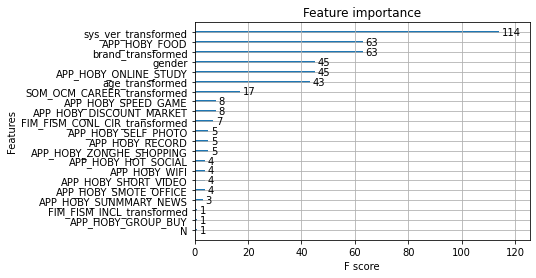

In [66]:
plot_importance(model)

# 最优参数

In [63]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
continus_cols = ['APP_HOBY_SHORT_VIDEO',
                'APP_HOBY_SUMMARY_VIDEO' ,
                'APP_HOBY_SELF_PHOTO' ,
                'APP_HOBY_SUNMMARY_NEWS' ,
                'APP_HOBY_SPEED_GAME',
                'APP_HOBY_WIFI',
                'APP_HOBY_FOOD',
                'APP_HOBY_RECORD',
                'APP_HOBY_HOT_SOCIAL' ,
                'APP_HOBY_ONLINE_STUDY' ,
                'APP_HOBY_ZONGHE_SHOPPING' ,
                'APP_HOBY_DISCOUNT_MARKET' ,
                'APP_HOBY_GROUP_BUY' ,
                'APP_HOBY_SMOTE_OFFICE',  
               ]

category_cols = ["gender", "age_transformed", 'sys_ver_transformed', 'brand_transformed',
                 "SOM_OCM_CAREER_transformed",
                 "CPL_INDM_EDU_LEVEL_transformed",
                 "CPL_INDM_MARRC2_transformed",    
                 "FIM_FISM_INCL_transformed", 
                 'FIM_FISM_CONL_CIR_transformed',
                  'N',
                 'big_offs',
                  ]
preprocessor = ColumnTransformer(
                 transformers=[
#                      ("none", FunctionTransformer(lambda x: x), continus_cols), 
                    ("onehot", OneHotEncoder(handle_unknown='ignore'), category_cols)
                    ])

# train = preprocessor.fit_transform(jg_sg_df3[category_cols])
train_y = jg_sg_df3['pref'].tolist()

In [62]:
jg_sg_df3.pref.value_counts()

0    17596
1     7014
Name: pref, dtype: int64

In [70]:
# feat=jg_sg_df3[jg_sg_df3.pref1 != -1][category_cols+continus_cols]
# feat_y=jg_sg_df3[jg_sg_df3.pref1 != -1]['pref1']
# feat=up_train_df[category_cols+continus_cols]
feat=jg_sg_df3[jg_sg_df3.pref1!=-1][category_cols+continus_cols]
feat_y=jg_sg_df3[jg_sg_df3.pref1!=-1]['pref1']
import hyperopt 
auc_list=[]
def hyperopt_objective(params):
    

    model = XGBClassifier(
        objective= 'binary:logistic',
        max_depth=int(params['max_depth']) + 3,
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        min_child_weight=int(params['min_child_weight']),
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        gamma=params["gamma"]

    )
     
    res = np.mean(cross_val_score(model,feat, feat_y, cv=5, n_jobs=-1, scoring='roc_auc'))
    print("*" * 30)
    print(params)
    print("roc_auc: {}".format(res))
    auc_list.append(res)
    return 1 - res
params_space = {

    'max_depth': hyperopt.hp.randint('max_depth', 2,6),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 3e-1),
    'n_estimators': hyperopt.hp.quniform("n_estimators", 100, 200, 10),
    'min_child_weight': hyperopt.hp.randint('min_child_weight', 5),
    'subsample': hyperopt.hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.6, 1),
    'gamma': hyperopt.hp.uniform('gamma', 0, 0.3)
}
trials = hyperopt.Trials()
best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=20,    #100
    trials=trials)

print("最佳参数")
Eprint(best,"roc_auc: {}".format(max(auc_list)))

******************************                        
{'colsample_bytree': 0.6720943822491531, 'gamma': 0.2833000657548488, 'learning_rate': 0.025831969553763084, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 130.0, 'subsample': 0.7032536761833335}
roc_auc: 0.637692018547696                            
******************************                                                   
{'colsample_bytree': 0.6872167942457889, 'gamma': 0.10985698398405576, 'learning_rate': 0.015358251276412268, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 110.0, 'subsample': 0.8313871378093683}
roc_auc: 0.6423994749766415                                                      
******************************                                                   
{'colsample_bytree': 0.628226941831726, 'gamma': 0.11188859071935249, 'learning_rate': 0.2706206103763145, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 120.0, 'subsample': 0.9713007113633623}
roc_auc: 0.5867532979632184      

NameError: name 'Eprint' is not defined

# 原生接口

[0]	eval-auc:0.55992	train-auc:0.58519
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 20 rounds.
[1]	eval-auc:0.59393	train-auc:0.61228
[2]	eval-auc:0.59777	train-auc:0.61252
[3]	eval-auc:0.60139	train-auc:0.61392
[4]	eval-auc:0.62338	train-auc:0.64253
[5]	eval-auc:0.62638	train-auc:0.64221
[6]	eval-auc:0.63318	train-auc:0.65001
[7]	eval-auc:0.63385	train-auc:0.65144
[8]	eval-auc:0.63411	train-auc:0.65193
[9]	eval-auc:0.63256	train-auc:0.65169
[10]	eval-auc:0.63468	train-auc:0.65202
[11]	eval-auc:0.63435	train-auc:0.65191
[12]	eval-auc:0.63487	train-auc:0.65259
[13]	eval-auc:0.63719	train-auc:0.65238
[14]	eval-auc:0.63610	train-auc:0.65196
[15]	eval-auc:0.63740	train-auc:0.65270
[16]	eval-auc:0.63828	train-auc:0.65224
[17]	eval-auc:0.63833	train-auc:0.65227
[18]	eval-auc:0.64031	train-auc:0.65510
[19]	eval-auc:0.63907	train-auc:0.65557
[20]	eval-auc:0.63792	train-auc:0.65551
[21]	eval-auc:0.63732	train

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

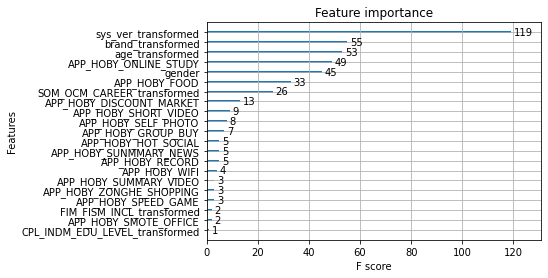

In [69]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
temp=jg_sg_df3[jg_sg_df3.pref1 != -1]
# temp=up_train_df

# temp=down_train_df

col_feature = col_feat

col_label = 'pref1'

train_X,test_X,train_y,test_y =train_test_split(temp[col_feature],temp[col_label],test_size=0.3)

params = {
    'booster': 'gbtree',                           #使用不同的booster
    'objective': 'binary:logistic', 
        'gamma': 0.2809160558434579,               #默认0，min_split_loss 树的叶节点进一步分区所需最小损失 [0,∞]
    'max_depth': 2,                                #默认6 一棵树的最大深度，越大越易过拟合   [0,∞]
#         'reg_lambda': 10,                        #默认1 L2正则项，越大模型越保守
    'subsample':0.7383894518908453,                #默认1 训练实例的子样本比例  0.5意味着XGBoost将在树木生长之前随机采样一半的训练数据,可防止过拟合 (0,1]
    'colsample_bytree': 0.6506463468023698,        #默认1 用于列二次采样的参数  (0,1]
    'min_child_weight': 3,                         #默认1 子级中实例重量的最小总和（hessian）。越大算法将越保守。 [0,∞]
    'eta': 0.021399381907086172,                  #默认0.3 学习率   [0,1]
    'seed': 1000,
    'nthread': 4,
#     'scale_pos_weight':17596/7014,
     'eval_metric':['auc'],
}

dtrain = xgb.DMatrix(train_X, train_y)
dtest = xgb.DMatrix(test_X, test_y)
num_rounds = 150
model=xgb.train(params, dtrain, num_rounds, [(dtest, 'eval'), (dtrain,'train')],early_stopping_rounds=20)

# 对测试集进行预测
dtest = xgb.DMatrix(test_X)
y_pred = model.predict(dtest)
y_pred = [round(value) for value in y_pred]
 
# 计算准确率
accuracy = accuracy_score(test_y,y_pred)
print('accuarcy:%.2f%%'%(accuracy*100))
 
# 显示重要特征
plot_importance(model)


# lightgbm

In [67]:
import lightgbm as lgb

num_round = 100
temp = jg_sg_df3
# col_feat = ['brand_transformed', 'sys_ver_edited_transformed', 'gender', 'birthyear']
col_ans = 'pref'


params = {'num_leaves': 60, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 50,
          'objective': 'binary', #定义的目标函数
          'max_depth': -1,
          'learning_rate': 0.03,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 0.9,	#提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1, #l1正则
          # 'lambda_l2': 0.001, #l2正则
          "verbosity": -1,
          "nthread": 3, #线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'auc'}, #评价函数选择
          "random_state": 2019,	#随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

folds = KFold(n_splits=5, shuffle=True, random_state=2019)
# prob_oof = np.zeros((train_x.shape[0], ))
# test_pred_prob = np.zeros((test.shape[0], ))


## train and predict
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(temp)):
    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(temp.iloc[trn_idx][col_feat], label=temp.iloc[trn_idx][col_ans])
    val_data = lgb.Dataset(temp.iloc[val_idx][col_feat], label=temp.iloc[val_idx][col_ans])


    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=5,
                    early_stopping_rounds=60)
    #prob_oof[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)

#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    #test_pred_prob += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

# threshold = 0.5
# for pred in test_pred_prob:
#     result = 1 if pred > threshold else 0
    
    

fold 1
Training until validation scores don't improve for 60 rounds
[5]	training's auc: 0.653381	valid_1's auc: 0.568119
[10]	training's auc: 0.666066	valid_1's auc: 0.577874
[15]	training's auc: 0.674283	valid_1's auc: 0.580732
[20]	training's auc: 0.684004	valid_1's auc: 0.58221
[25]	training's auc: 0.692556	valid_1's auc: 0.584596
[30]	training's auc: 0.701149	valid_1's auc: 0.586543
[35]	training's auc: 0.707539	valid_1's auc: 0.586054
[40]	training's auc: 0.713427	valid_1's auc: 0.586298
[45]	training's auc: 0.719762	valid_1's auc: 0.586997
[50]	training's auc: 0.725718	valid_1's auc: 0.587762
[55]	training's auc: 0.732831	valid_1's auc: 0.587544
[60]	training's auc: 0.737875	valid_1's auc: 0.587689
[65]	training's auc: 0.743527	valid_1's auc: 0.587317
[70]	training's auc: 0.749155	valid_1's auc: 0.587389
[75]	training's auc: 0.754785	valid_1's auc: 0.586453
[80]	training's auc: 0.760318	valid_1's auc: 0.585809
[85]	training's auc: 0.76706	valid_1's auc: 0.584394
[90]	training's a